vals= [-0.2311522   0.08249166 -0.39674699 -0.45642764 -0.30899082]
L= 2
L= 4
L= 8
L= 16
L= 32
L= 64
L= 128
L= 256
L= 512
L= 1024
L= 2048


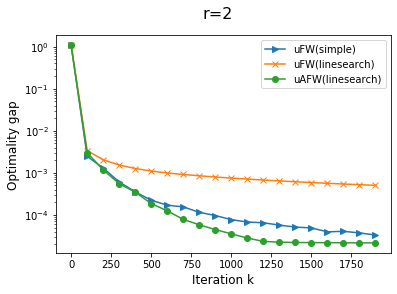

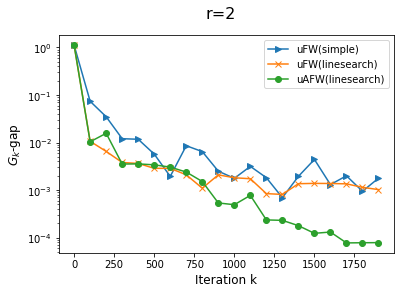

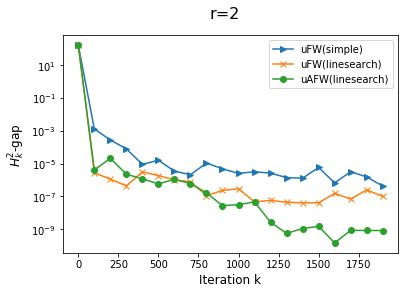

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from Mosek_Leastsquares import Mosek_Leastsquares
from uFW_Leastsquares import *
from uAFW_Leastsquares import *
import utils




def my_plotting_LeastSquares(Img_ID, r, N, n, relative_delta, relative_sigma, repeat, myseed, itermax = 2000):
    #####################################################################
    ## Plot the experiments results on trend filtering with quadratic loss.
    ## All the images are saved in a folder named 'Images'.
    ## 
    ##
    ## Input:
    ##
    ## Img_ID: Int
    ## This parameter is used to give different names when saving the images.
    ##
    ## r: The order of difference for D^(r).
    ##
    ## N: The number of samples.
    ##
    ## n: The number of features.
    ##
    ## relative_delta: Relative value w.r.t. the genrated data beforing noising. (See captions of plotted figures in the latex code).
    ##
    ## relative_sigma: Relative noise level (See captions of plotted figures in the latex code).
    ##
    ## repeat: The number of independent experiments.
    ##
    ## itermax: The total number of iterations for each method.
    ##
    ##
    ####################################################################


    if r == 1:
        delta = relative_delta * 1
        piece_type = 'contant'
    else:
        if r == 2:
            delta = relative_delta * 1
            piece_type = 'linear'

    time_vec11_ave, time_vec12_ave, time_vec2_ave = 0,0,0
    relative_gap11_ave, relative_gap12_ave, relative_gap2_ave = 0,0,0
    G_11_ave, G_12_ave, G_2_ave = 0,0,0
    H_11_ave, H_12_ave, H_2_ave = 0,0,0

    for j in range(repeat):
#         A = np.random.randn(N,n)
#         b = generate_data_leastsquare(A, r, N, n, relative_sigma)
        m = 5
        A, b, x_true = utils.gen_data_leastsquares(N, n, r, m, relative_sigma, myseed)
        

        ## Output the cpu time and objective values in each iteration for different methods
        time_cvxpy, cvxpy_opt = Mosek_Leastsquare(r, A, b, delta)

        x11, time_vec11, obj_val11, G_vec11, H_vec11, _ = uFW_Leastsquares(r, A, b, delta, 'simple', itermax=itermax)
        x12, time_vec12, obj_val12, G_vec12, H_vec12, _ = uFW_Leastsquares(r, A, b, delta, 'linesearch', itermax=itermax)
        x2, time_vec2, obj_val2, G_vec2, H_vec2, _ = uAFW_Leastsquares(r, A, b, delta, itermax=itermax)

        relative_gap11 = (obj_val11 - cvxpy_opt)/max(1, cvxpy_opt)
        relative_gap12 = (obj_val12 - cvxpy_opt)/max(1, cvxpy_opt)
        relative_gap2 = (obj_val2 - cvxpy_opt)/max(1, cvxpy_opt)
        
        best_past_obj11 = np.minimum.accumulate(obj_val11)
        best_past_obj12 = np.minimum.accumulate(obj_val12)
        best_past_obj2 = np.minimum.accumulate(obj_val2)
        
        best_past_obj11 = (best_past_obj11>1)*best_past_obj11 + 1*(best_past_obj11<1)
        best_past_obj12 = (best_past_obj12>1)*best_past_obj12 + 1*(best_past_obj12<1)
        best_past_obj2 = (best_past_obj2>1)*best_past_obj2 + 1*(best_past_obj2<1)

        
#         best_past_obj11 = np.array([np.min(obj_val11[0:i]) for i in range(np.shape(obj_val11)[0])])
#         best_past_obj12 = np.array([np.min(obj_val12[0:i]) for i in range(np.shape(obj_val12)[0])])
#         best_past_obj2 = np.array([np.min(obj_val2[0:i]) for i in range(np.shape(obj_val2)[0])])
        
        rel_G11 = G_vec11/best_past_obj11
        rel_G12 = G_vec12/best_past_obj12
        rel_G2 = G_vec2/best_past_obj2
        
        rel_H11 = H_vec11**2/best_past_obj11
        rel_H12 = H_vec12**2/best_past_obj12
        rel_H2 = H_vec2**2/best_past_obj2

        relative_gap11_ave += relative_gap11
        relative_gap12_ave += relative_gap12
        relative_gap2_ave += relative_gap2
        
        time_vec11_ave += time_vec11
        time_vec12_ave += time_vec12
        time_vec2_ave += time_vec2
        
        G_11_ave += rel_G11
        G_12_ave += rel_G12
        G_2_ave += rel_G2
        
        H_11_ave += rel_H11
        H_12_ave += rel_H12
        H_2_ave += rel_H2


    time_vec11_ave /= repeat
    time_vec12_ave /= repeat
    time_vec2_ave /= repeat

    relative_gap11_ave /= repeat
    relative_gap12_ave /= repeat
    relative_gap2_ave /= repeat
    
    G_11_ave /= repeat
    G_12_ave /= repeat
    G_2_ave /= repeat
    
    H_11_ave /= repeat
    H_12_ave /= repeat
    H_2_ave /= repeat


    ## Plot a point every (itermax/20) iterations
    plot_gap = int(itermax/20)
    plot_index = [plot_gap * i for i in range(20)]
    relative_gap11_plot = relative_gap11_ave[plot_index]
    relative_gap12_plot = relative_gap12_ave[plot_index]
    relative_gap2_plot = relative_gap2_ave[plot_index]

    time_vec11_plot = time_vec11_ave[plot_index]
    time_vec12_plot = time_vec12_ave[plot_index]
    time_vec2_plot = time_vec2_ave[plot_index]
    
    G_11_plot = G_11_ave[plot_index]
    G_12_plot = G_12_ave[plot_index]
    G_2_plot = G_2_ave[plot_index]
    
    H_11_plot = H_11_ave[plot_index]
    H_12_plot = H_12_ave[plot_index]
    H_2_plot = H_2_ave[plot_index]



    ### Start plotting
    ## Plot 1: Iterations vs Relative gap
    x_axis = plot_index
    fig1 = plt.figure()
    plt.plot(x_axis,relative_gap11_plot,'>-', label='uFW(simple)')
    plt.plot(x_axis,relative_gap12_plot,'x-', label='uFW(linesearch)')
    plt.plot(x_axis,relative_gap2_plot,'o-', label='uAFW(linesearch)')
    plt.legend()
    fig1.suptitle("r=%d" %(r), fontsize=16)

    plt.gca().set_yscale('log')
    plt.xlabel('Iteration k', fontsize = 12)
    plt.ylabel('Optimality gap', fontsize = 12)
#     plt.savefig('Images/Leastsquare_Iterations_vs_RelativeGap_r=%d.pdf' %(r))
    plt.show()
    
    ## Plot 2: Iterations vs G
    fig2 = plt.figure()
    plt.plot(x_axis,G_11_plot,'>-', label='uFW(simple)')
    plt.plot(x_axis,G_12_plot,'x-', label='uFW(linesearch)')
    plt.plot(x_axis,G_2_plot,'o-', label='uAFW(linesearch)')
    plt.legend()
    fig2.suptitle("r=%d" %(r), fontsize=16)
    
    plt.gca().set_yscale('log')
    plt.xlabel('Iteration k', fontsize = 12)
    plt.ylabel('$G_k$-gap', fontsize = 12)
#     plt.savefig('Images/Leastsquare_Iterations_vs_G_r=%d.pdf' %(r))
    plt.show()
    
    
    ## Plot 3: Iterations vs H
    fig3 = plt.figure()
    plt.plot(x_axis,H_11_plot,'>-', label='uFW(simple)')
    plt.plot(x_axis,H_12_plot,'x-', label='uFW(linesearch)')
    plt.plot(x_axis,H_2_plot,'o-', label='uAFW(linesearch)')
    plt.legend()
    fig3.suptitle("r=%d" %(r), fontsize=16)
    
    plt.gca().set_yscale('log')
    plt.xlabel('Iteration k', fontsize = 12)
    plt.ylabel('$H_k^2$-gap', fontsize = 12)
#     plt.savefig('Images/Leastsquare_Iterations_vs_H_r=%d.pdf' %(r))
    plt.show()
    


myseed = 1
my_plotting_LeastSquares(Img_ID= 6, r = 2, N=1000, n=500, relative_delta= 1, relative_sigma= np.sqrt(1/1), repeat = 1, myseed=myseed, itermax = 2000)


